<a href="https://colab.research.google.com/github/BastienBoucherat/geo6149/blob/main/geo6149_projet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Etude de la capacité théorique d'autonomie alimentaire du territoire**
---

GEO-6149: Géomatique

*   Bastien Boucherat (20155314)
*   Juliette Goulet ()


# **Configuration de l'étude**

In [1]:
# Coordinate system used throughout the study
study_crs = 'EPSG:32188'

# **Configuration de l'environnement de travail**
*    Création des dossiers sur Google Colab
*    Installation de paquets python additionnels
*    Importation des paquets python nécessaires

## Quelques définitions

Définitions relatives à l'analyse géomatique

In [2]:
# Coordinate system for Latitude-Longitude
geo_crs = 'EPSG:4326'

# Projection used for plots (web Mercator)
plot_crs = 'EPSG:3857'

Définitions relatives à la gestion des fichiers sur Google Colab

In [3]:
# This folder is the projet root folder in Google Colab
project_folder = "/content"

## Arborescence des dossiers
Création de quelques dossiers de travail sur Google Colab.

In [4]:
# Packages necessary to handle files in Google Colab.
# https://docs.python.org/3/library/os.path.html
import os
import os.path

# This folder contains temporary files
tmp_folder = project_folder + "/tmp"

# Create folder is not already there
if not os.path.exists(tmp_folder):
    os.mkdir(tmp_folder)

# This folder will contain persistent data
data_folder = project_folder + "/data"

# Create folder is not already there
if not os.path.exists(data_folder):
    os.mkdir(data_folder)

## Installation des paquets

Installation de **GeoPandas** pour le traitement des données géospatiales

In [5]:
# Install Geopandas
%%capture
!apt-get install -qq curl g++ make
!curl -L http://download.osgeo.org/libspatialindex/spatialindex-src-1.8.5.tar.gz | tar xz
import os
os.chdir('spatialindex-src-1.8.5')
!./configure
!make
!make install
!pip install rtree
!ldconfig
!pip install geopandas

Installation de **RasterIO** pour le traitement des données matricielles

In [6]:
# Install rasterIO
%%capture
!pip install rasterio

Installation de **Contextily** pour ajouter des fonds de cartes

In [7]:
# Install contextily for map visualisation
%%capture
!pip install contextily

## Importation des paquets

In [8]:
# Data processing
import numpy as np
import pandas as pd


In [9]:
# Geodata processing

# Geopandas
import geopandas as gpd

# https://rasterio.readthedocs.io/en/latest/intro.html
import rasterio
import rasterio.plot
import rasterio.mask

In [10]:
# Data format
import json

In [11]:
# Data visualisation
import matplotlib.pyplot as plt
import contextily as cx

# **Chargement des données distantes**

*   Chargement de la configuration des sources de données
*   Téléchargement des données distantes
*   Extraction des archives compressées (au besoin)
*   Sauvegarde des fichiers nécessaires
*   Suppression des fichiers inutiles

## Chargement de la configuration des sources
La configuration est contenue dans un fichier de description des sources de donnnées distantes

In [12]:
# Load remote data sources information
data_sources_df = pd.read_csv(project_folder + '/data_sources.csv')

# Download only from selected data sources
data_sources_df = data_sources_df[data_sources_df['Use?']==True]

## Copie des données distantes

In [13]:
%%capture

# Remote files will be downloaded and extracted in this folder
# Then, downloaded files will be used to generate pre-processed data files eventually stored locally in another folder
%cd {tmp_folder}

# For selected each source
for idx, data_source in data_sources_df.iterrows():

    # This will point to the useful file to save
    useful_file = ''

    # Get some information from the link
    data_file = data_source['Link'].split('/')[-1]
    data_file_name = data_file.split('.')[0]
    data_file_type = data_file.split('.')[-1] # file extension
    
    # Download source from internet
    if not os.path.exists(data_file):
        source_url = data_source['Link']
        # wget [URL] -P [Directory]
        !wget $source_url
    
    # Extract (if applicable)
    if data_file_type.lower() in ['zip']:

        # Where?
        extract_folder = data_file_name
 
        # Extract
        !unzip -u $data_file -d $extract_folder

        # Save path to file
        useful_file= useful_file + f"{extract_folder}/{data_source['File Name']}"
    else:
        # Save path to file
        useful_file = data_file_name

    # Save the useful files to a persistent folder

    # Shapefile
    if data_source['Format'] == 'shapefile':

        # List of desired file types
        file_types = ['shp','shx','dbf','prj']

        # Target files
        target_file = f"{data_folder}/{data_source['Type']}_{data_source['Area']}"

        # Copy all necessary files
        for file_type in file_types:
            src_file = f'{useful_file}.{file_type}'
            dest_file = f'{target_file}.{file_type}'
            !cp $src_file $dest_file

        # Save the data location
        data_sources_df.at[data_source['index'],'Location'] = f'{target_file}.shp'
    
    # Geotiff
    elif data_source['Format'] == 'geotiff':
        
        # List of desired file types
        file_types = ['tif','tiff']

        # Target files
        target_file = f"{data_folder}/{data_source['Type']}_{data_source['Area']}"
        print(f"Target file: {target_file}")

        # Try for every potentiel type of file
        for file_type in file_types:

            src_file = f'{useful_file}.{file_type}'
            print(f"Target file: {src_file}")
            # Copy every file that is found
            if os.path.exists(src_file):
                dest_file = f'{target_file}.{file_type}'
                dest_file_type = file_type
                !cp $src_file $dest_file
        
        # Save the data location
        data_sources_df.at[data_source['index'],'Location'] = f'{target_file}.{dest_file_type}'

## Nettoyage des fichiers temporaires


In [14]:
# Remove temporary files
if True:
    # Remove files from extraction folders
    command = f'{tmp_folder}/*/*'
    !rm $command
    # Remove extraction folders themselves
    command = f'{tmp_folder}/*'
    !rmdir $command

# Remove downloaded source files
if False:
    # Remove zip files
    command = f'{tmp_folder}/*.zip'
    !rm $command

# Remove useless columns from data source description
data_sources_df = data_sources_df.drop(['Link', 'Use?', 'File Name'], axis='columns')

rmdir: failed to remove '/content/tmp/cb_2018_us_state_500k.zip': Not a directory
rmdir: failed to remove '/content/tmp/GHSL_data_54009_shapefile.zip': Not a directory
rmdir: failed to remove '/content/tmp/lpr_000b16a_e.zip': Not a directory
rmdir: failed to remove '/content/tmp/ppp_2020_1km_Aggregated.tif': Not a directory


# **Préparation des données génériques**

### Données administratives

**Chargement des frontières administratives** (Etats-Unis)

In [15]:
# Select US boundaries
file_name = data_sources_df[(data_sources_df['Type'] == 'Boundaries') & (data_sources_df['Area'] == 'USA')]['Location'].item()

# Load vector data
us_boundaries_gdf = gpd.read_file(file_name)

# Check coordinate system
if us_boundaries_gdf.crs == 'None':
    print("Error: CRS information is missing")
else:
    us_boundaries_gdf = us_boundaries_gdf.to_crs(study_crs)

# Cherry-pick and rename information
us_boundaries_gdf['NATION_ID']="USA"
us_boundaries_gdf = us_boundaries_gdf.rename(columns={'STUSPS':'SUB_NATION_ID','NAME':'SUB_NATION_NAME'})
us_boundaries_gdf = us_boundaries_gdf[['NATION_ID', 'SUB_NATION_ID', 'SUB_NATION_NAME', 'geometry']]

In [16]:
# States that are outside North American continent: Samoa, Virgin Islands, Guam, Mariana Islands, Hawai, Puerto Rico
outside_states = ['AS','VI','GU', 'MP', 'HI', 'PR']

# Remove states outisde of North America
us_boundaries_gdf = us_boundaries_gdf[~us_boundaries_gdf['SUB_NATION_ID'].isin(outside_states)]

**Chargement des frontières administratives** (Canada)

In [17]:
# Select Canada boundaries
file_name = data_sources_df[(data_sources_df['Type'] == 'Boundaries') & (data_sources_df['Area'] == 'Canada')]['Location'].item()

# Load vector data
can_boundaries_gdf = gpd.read_file(file_name)

# Check coordinate system
if can_boundaries_gdf.crs == 'None':
    print("Error: CRS is missing")
else:
    can_boundaries_gdf = can_boundaries_gdf.to_crs(study_crs)

# Cherry-pick and rename information
can_boundaries_gdf['NATION_ID']="CAN"
can_boundaries_gdf = can_boundaries_gdf.rename(columns={'PREABBR':'SUB_NATION_ID','PRENAME':'SUB_NATION_NAME'})
can_boundaries_gdf = can_boundaries_gdf[['NATION_ID', 'SUB_NATION_ID', 'SUB_NATION_NAME', 'geometry']]

**Sauvegarde des donnnées administratives** (Canada et Etat-Unis)

In [18]:
# Merge data for Canada+USA
boundaries_gdf = us_boundaries_gdf.append(can_boundaries_gdf)

# Define index
boundaries_gdf.set_index(['NATION_ID', 'SUB_NATION_ID'], inplace=True)

<ipython-input-18-733300387243>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  boundaries_gdf = us_boundaries_gdf.append(can_boundaries_gdf)


In [19]:
# Geometries from Statistiques Canada are really precise, hence very heavy.
# Let's make data lighter: this is done on all boundaries (US and Canada) so that precision is consistent across data
minimum_distance_km = 10
boundaries_gdf['geometry'] = boundaries_gdf['geometry'].simplify(minimum_distance_km*1000, preserve_topology = 'True')

In [20]:
# Save as a file
pd.DataFrame(boundaries_gdf).to_csv(data_folder + '/Boundaries.csv')

# **Définition de la zone d'étude**

## Centres urbains

Définition des centres urbains à considérer dans notre analyse.



In [21]:
from shapely.geometry import Polygon, LineString, Point

# Create a list of the urban centers to include in the study
urban_centers_names = ["Montreal"]

# TODO: use Google maps API to get coordinates from names
# For now, manually provide coordinates
urban_centers_coordinates = [[-73.623983, 45.512047]]

# Create a geometry from the coordinates
# TODO: handle more than one urban center
urban_centers_geometry = [Point(urban_centers_coordinates[0])]

# Save information as geodataframe associating urban centers with their respective geometry
urban_centers = gpd.GeoDataFrame({'Name': urban_centers_names, 'geometry': urban_centers_geometry}, geometry='geometry')

# Provide the coordinate system
urban_centers.crs = geo_crs

# Project to the desired CRS
urban_centers = urban_centers.to_crs(study_crs)

## Zone d'étude

In [22]:
# Center the study area on a city
study_area_center = urban_centers[urban_centers['Name']=='Montreal']

# Create a study area around this center
radius_km = 300
study_area = study_area_center.buffer(radius_km*1000, resolution=16)

# Create geodataframe from geometry
study_gdf = gpd.GeoDataFrame(geometry=study_area)

# Provide the CRS with which is was created
study_gdf.crs = study_crs

# Save the geometry as geoJSON
# geoJSON format requires EPSG:4326
file_name = "study_area.geojson"
study_gdf.to_crs(geo_crs).to_file(f'{project_folder}/{file_name}', driver='GeoJSON')

Afficher la zone d'étude

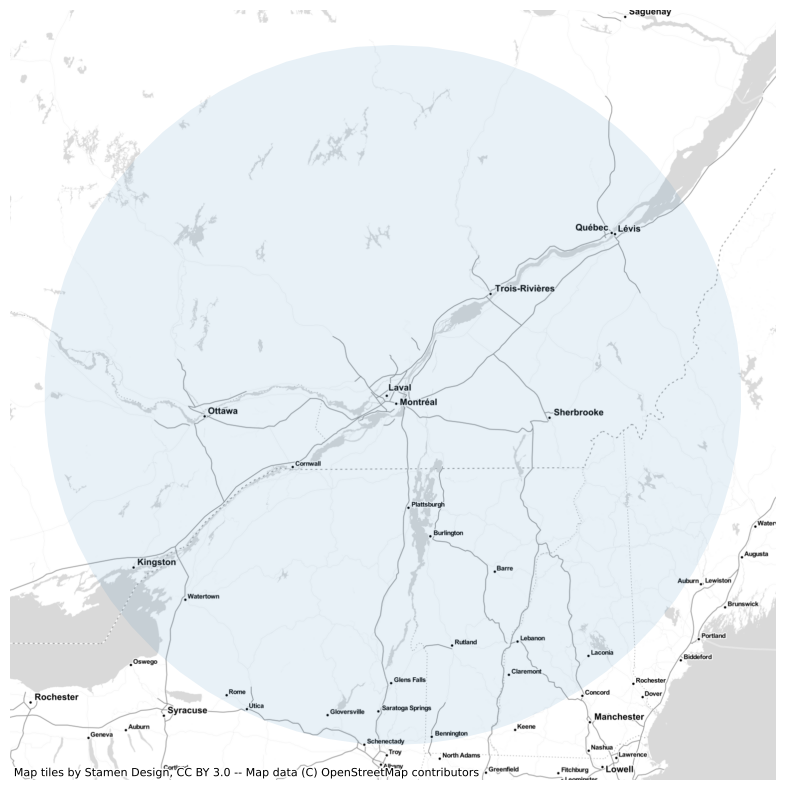

In [23]:
# Create a layer containing the study area
layer_1 = study_gdf.to_crs(plot_crs).plot(alpha=0.1, figsize=(10, 10))

# Beautify https://geopandas.org/en/stable/gallery/plotting_basemap_background.html
cx.add_basemap(layer_1, source=cx.providers.Stamen.TonerLite, zoom=8)
layer_1.set_axis_off()

# **Préparation des données pour la zone d'étude**

## Population (données matricielles)

In [24]:
# Population raster file
file_name = 'Population_World.tif'

# Load population raster
pop_raster = rasterio.open(f'{data_folder}/{file_name}')

# Check coordinate system
if pop_raster.crs != geo_crs:
    print("Warning: CRS is not latitude-longitude")

In [25]:
# Create a mask corresponding to the study area
# rasterio requires a geoJSON, and geoJSON requires latitude-longitude coordinates
study_mask = [json.loads(study_gdf.to_crs(geo_crs).to_json())['features'][0]['geometry']]

# Clip the population raster with the mask
# The clipped output loses the geospatial information
# So we also save the the geospatial information alongside
study_pop_np, study_pop_transform = rasterio.mask.mask(pop_raster, study_mask, crop=True)

# Reintegrate geopspatial information
study_pop_metadata = pop_raster.meta # reuse the metadata from the original file
study_pop_metadata.update({"driver": "GTiff",
                           "height": study_pop_np.shape[1],
                           "width": study_pop_np.shape[2],
                           "transform": study_pop_transform})

# Save the clipped population raster (i.e. limited to the study area)
with rasterio.open(data_folder + "/Population_study.tif", "w", **study_pop_metadata) as dest:
    dest.write(study_pop_np)

/usr/local/lib/python3.9/dist-packages/matplotlib/image.py:505: RuntimeWarning: overflow encountered in multiply
  A_resampled *= ((a_max - a_min) / frac)


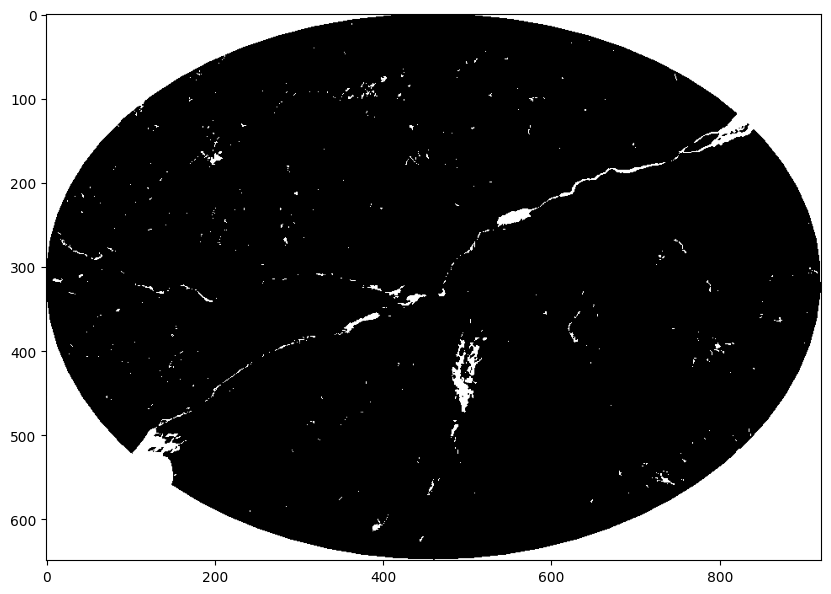

In [26]:
# Quick show of the clipped data according to the mask
plt.figure(figsize = (10,10))
plt.imshow(study_pop_np[0], cmap='Greys')

# **Analyse des données pour la zone d'étude**

## Chargements des données 

### Données de population

In [47]:
# Population raster file for our study
file_name = 'Population_study.tif'

# Load population raster
study_pop_raster = rasterio.open(f'{data_folder}/{file_name}')

Définition d'une fonction qui crée un masque circulaire.

In [66]:
##########################################
# Function: get_circular_mask
# Returns a circular mask
##########################################
def get_circular_mask(radius_km, center_gdf):

    # Create geometry
    circle_geometry = center_gdf.buffer(radius_km*1000, resolution=16)

    # Create geodataframe
    circle_gdf = gpd.GeoDataFrame(geometry=circle_geometry)

    # Provide the proper CRS to geodataframe
    circle_gdf.crs = center_gdf.crs

    # Create mask from geodataframe
    circle_mask = [json.loads(circle_gdf.to_crs(geo_crs).to_json())['features'][0]['geometry']]

    return circle_mask

#### *Quelques tests*

**Population dans la zone d'étude**

In [48]:
# Extract the population data from raster
pop_data = study_pop_raster.read()[0]

# Compute the total population present in the study area
print(f"There are around {round(sum(pop_data[pop_data>=0])/1e6,1)} million inhabitants in the study area")

There are around 11.7 million inhabitants in the study area


**Population du Québec**

In [49]:
# Extract the geodataframe for Quebec
qc_gdf = boundaries_gdf.loc[[('CAN','Que.')]]

In [50]:
# Create mask for Quebec
qc_mask = [json.loads(qc_gdf.to_crs(geo_crs).to_json())['features'][0]['geometry']]

# Load the population raster for the world
pop_raster = rasterio.open(f'{data_folder}/Population_World.tif')

# Extract the population data for Quebec from clipped raster
qc_pop_data = rasterio.mask.mask(pop_raster, qc_mask, crop=True)[0]

# Compute the total population of Quebec
print(f"There are around {round(sum(qc_pop_data[qc_pop_data>=0])/1e6,1)} million inhabitants in Quebec")

There are around 7.9 million inhabitants in Quebec


**Population d'un territoire quelconque**

On définit un territoire (ici une zone circulaire), puis on extrait des données de population grâce au masque, et enfin on calcule la population présente sur ce territoire.

In [65]:
# Define territory (center and size)
center = urban_centers[urban_centers['Name']=='Montreal']
radius_km = 10

# Create mask
territory_mask = get_circular_mask(radius_km, center)

# Extract the population data
territory_pop_data = rasterio.mask.mask(study_pop_raster, territory_mask, crop=True)[0]

# Compute the population for this territory
print(f"There are around {round(sum(territory_pop_data[territory_pop_data>=0])/1e6,1)} million inhabitants in the current territory")

There are around 1.5 million inhabitants in the current territory


## Calcul de l'autonomie alimentaire du territoire

* pour chaque ville
  * pour chaque taille
        creer une geometrie
        creer masque
        appliquer le masque aux donnees de population
        appliquer le masque aux donnees de production agricole
        calculer la population
        calculer la production
        calculer le niveau d'autonomie alimentaire

In [63]:
# Define territory center
circle_center = urban_centers[urban_centers['Name']=='Montreal']

# Check different sizes
circles_radius_km = [10, 50, 100]

results_list = []

# For each terrtory size
for radius_km in circles_radius_km:

    # Create mask for the territory
    circle_mask = get_circular_mask(radius_km, circle_center)

    # Extract the population data for the area considered in the evaluation
    pop_data = rasterio.mask.mask(study_pop_raster, circle_mask, crop=True)[0]

    # Store the results
    results_list.append({
      'City' : circle_center['Name'].item(),
      'Radius km': radius_km,
      'Population': round(sum(pop_data[pop_data>=0])),
      'Food': 0})


In [64]:
results_list

[{'City': 'Montreal', 'Radius km': 10, 'Population': 1542331, 'Food': 0},
 {'City': 'Montreal', 'Radius km': 50, 'Population': 4494248, 'Food': 0},
 {'City': 'Montreal', 'Radius km': 100, 'Population': 5506752, 'Food': 0}]